In [6]:
pip install statsmodels


<ipython-input-7-a2cca36f58c0>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Fill missing data


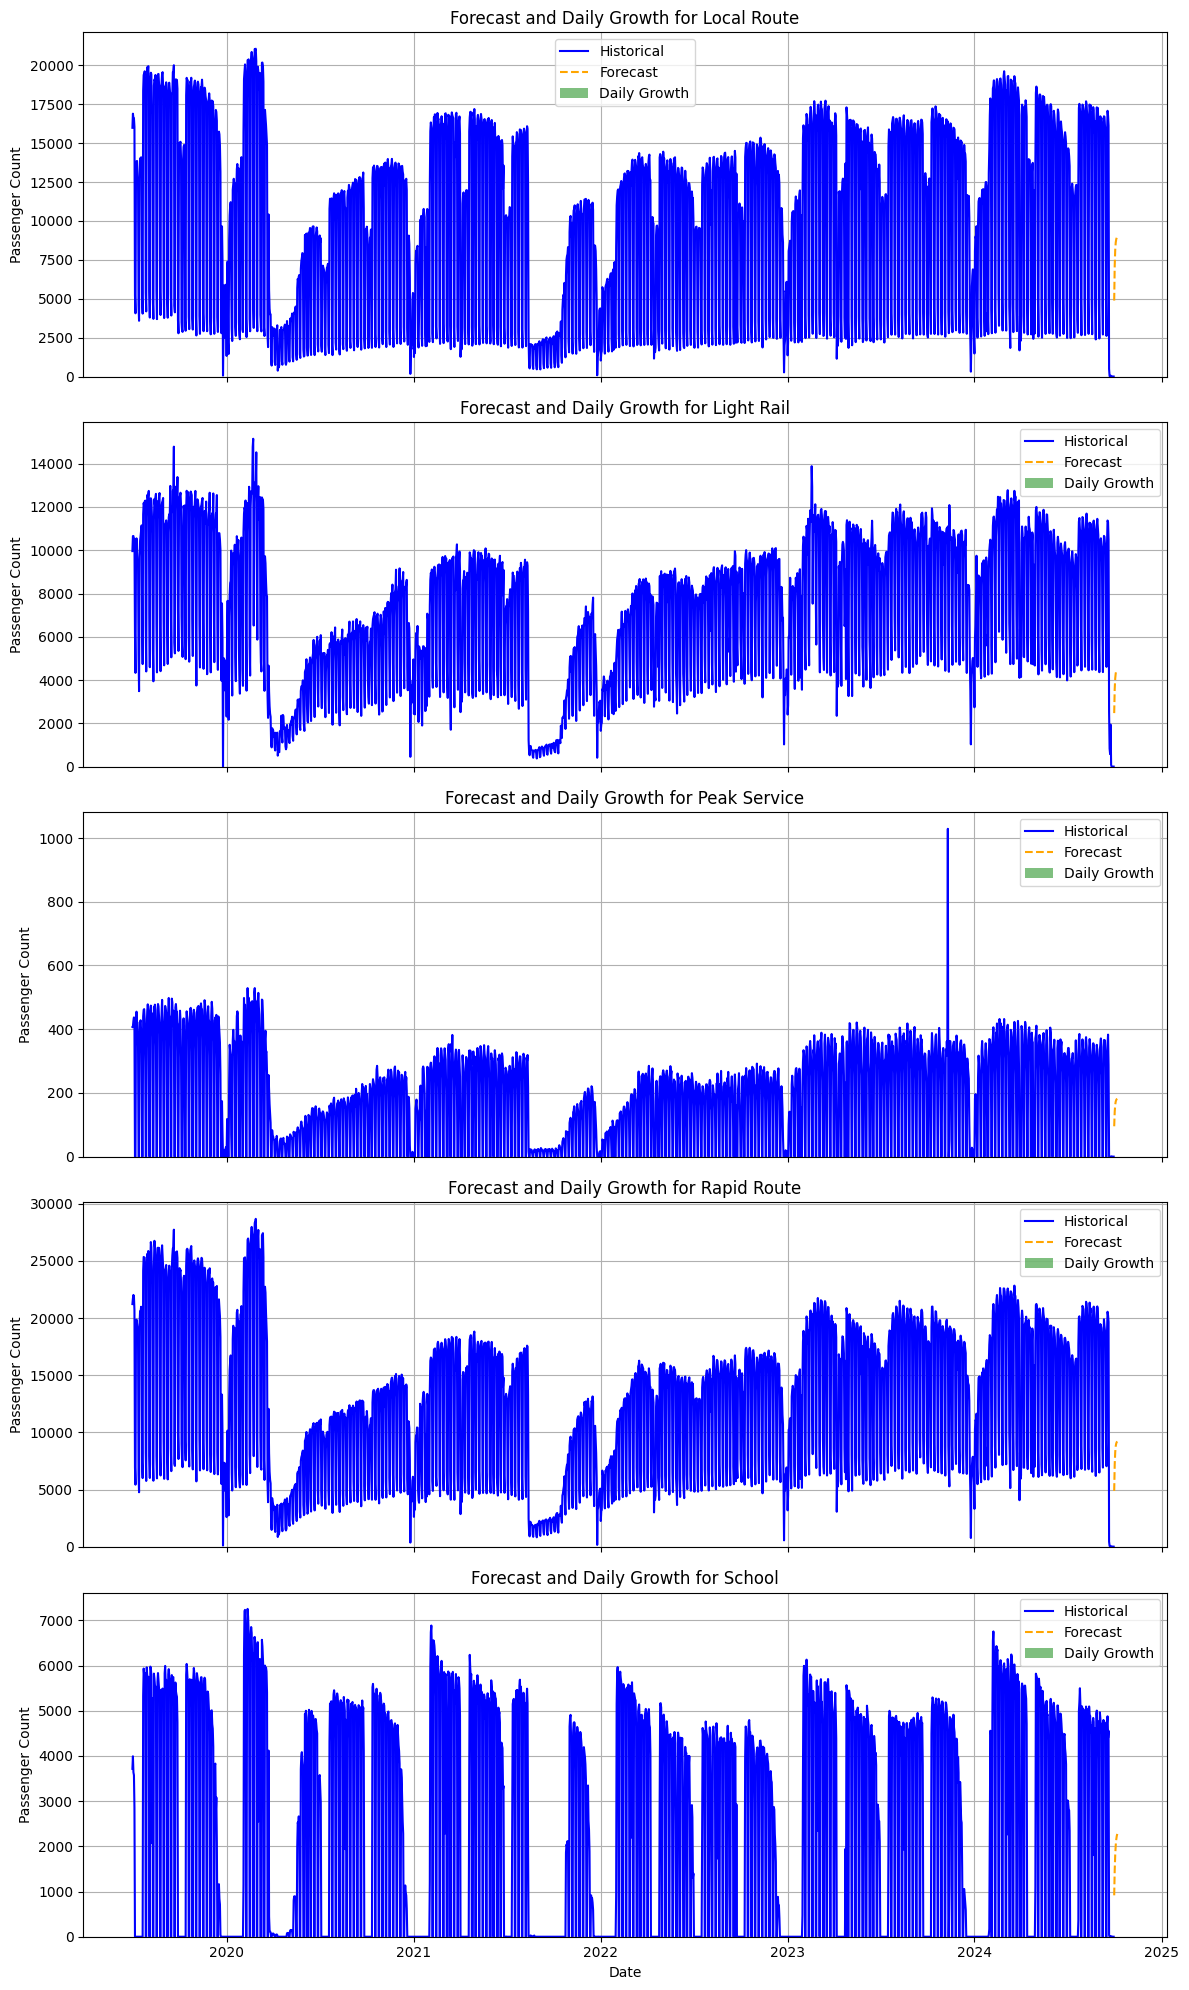

Forecasted passenger counts for the next 7 days:
            Local Route  Light Rail  Peak Service  Rapid Route  School
2024-09-30         4884        2473            95         4882     916
2024-10-01         7120        3585           141         7188    1475
2024-10-02         8144        4086           163         8278    1816
2024-10-03         8613        4311           173         8793    2024
2024-10-04         8828        4412           178         9037    2150
2024-10-05         8926        4458           180         9152    2228
2024-10-06         8971        4479           182         9207    2275


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').set_index('Date')
df = df.fillna(method='ffill')  # Fill missing data
df = df.asfreq('D')  # frequency(daily)

series_to_forecast = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

# Forecast horizon (7 days)
forecast_days = 7
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

forecasts = {}

for series_name in series_to_forecast:
    data = df[series_name]

    # Fit ARIMA(1,1,1) model (we can adjust order if needed)
    model = ARIMA(data, order=(1,1,1))
    model_fit = model.fit()

    # Forecast next 7 days
    forecast_values = model_fit.forecast(steps=forecast_days)
    forecasts[series_name] = pd.Series(forecast_values.values, index=future_dates)

# Combine all DF
forecast_df = pd.DataFrame(forecasts)

#  daily growth calculation
growth_df = forecast_df.diff().fillna(0)

# Plot res
fig, axes = plt.subplots(len(series_to_forecast), 1, figsize=(12, 4 * len(series_to_forecast)), sharex=True)

for i, series_name in enumerate(series_to_forecast):
    ax = axes[i]

    #  historical data
    ax.plot(df.index, df[series_name], label='Historical', color='blue')


    ax.plot(forecast_df.index, forecast_df[series_name], label='Forecast', color='orange', linestyle='--')


    bar_colors = growth_df[series_name].apply(lambda x: 'green' if x >= 0 else 'red')
    ax.bar(forecast_df.index, growth_df[series_name], color=bar_colors, alpha=0.5, label='Daily Growth')

    ax.set_title(f'Forecast and Daily Growth for {series_name}')
    ax.set_ylabel('Passenger Count')
    ax.legend()
    ax.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()


print("Forecasted passenger counts for the next 7 days:")
print(forecast_df.round().astype(int))
